In [2]:
import glob
import os
import re

import numpy as np
import pandas as pd
import sympy
from impedance.models.circuits import CustomCircuit
from tqdm.auto import tqdm  # noqa: F401

from helpers import *

os.environ["JAX_PLATFORM_NAME"] = "cpu"

import autoeis as ae  # noqa: E402

ae.visualization.set_plot_style()


# Bayesian inference

In [228]:
path_dataset = "dataset/PJ131"
path_eis = os.path.join(path_dataset, "eis-sorted/charge")
path_ecm = os.path.join(path_dataset, "ecm/charge")

# Load ECM and EIS data
ecm_file_list = glob.glob(os.path.join(path_ecm, "*.csv"))
ecm_file_list.sort(key=get_cycle_number)
eis_file_list = glob.glob(os.path.join(path_eis, "*.csv"))
eis_file_list.sort(key=get_cycle_number)

# Perform Bayesian inference using a single ECM on a single EIS dataset
circuits = ae.io.load_results_dataframe(ecm_file_list[0])
eis_data = ae.io.load_eis_data(eis_file_list[0], column_indices=[0, 1, 2])

# Provide the test_circuit and test_value
# circuit = circuits["circuitstring"][0]
# params = circuits["Parameters"][0]

# FIXME: For now commented: ECM is not good -> no ECM is left after applying filters
Zreal, Zimag = eis_data["Zreal"], eis_data["Zimag"]
ohmic_resistance = ae.core.find_ohmic_resistance(Zreal, Zimag)
circuits = ae.core.apply_heuristic_rules(circuits, ohmic_resistance)


In [2]:
def gen_expr(circuit):
    import re

    # Define two kinds of pattern to find all elements in the circuit
    test_pattern = re.compile(r"([CLRP])([0-9]+)+")
    test_pattern_2 = re.compile(r"[CLRP][0-9]+")

    # Create a list to store the mathematical expressions
    new_circuits = []

    for j, k in zip(["-", "[", ",", "]"], ["+", "((", ")**(-1)+(", ")**(-1))**(-1)"]):
        circuit = circuit.replace(j, k)
    test_results = test_pattern.findall(circuit)
    test_results_2 = test_pattern_2.findall(circuit)

    test_results.reverse()
    test_results_2.reverse()

    for m in range(len(test_results)):
        if test_results[m][0] == "R":
            circuit = circuit.replace(test_results_2[m], "X")
        elif test_results[m][0] == "C":
            circuit = circuit.replace(test_results_2[m], "(1/(2*1j*np.pi*F*X))")
        elif test_results[m][0] == "L":
            circuit = circuit.replace(test_results_2[m], "(2*1j*np.pi*F*X)")
        elif test_results[m][0] == "P":
            circuit = circuit.replace(
                test_results_2[m],
                # "X*(2*np.pi*F)**(-Y)*(np.cos((np.pi*Y)*0.5)-np.sin((np.pi*X)*0.5)*1j)",
                "(1/(X*(2*1j*np.pi*F)**(Y)))",  # modify the math function
            )

    new_temp_circuit = []
    counter = 0

    for n in range(len(circuit)):
        if circuit[n] == "X":
            new_temp_circuit.append(f"X[{str(counter)}]")
            counter += 1
        elif circuit[n] == "Y":
            new_temp_circuit.append(f"X[{str(counter)}]")
            counter += 1
        else:
            new_temp_circuit.append(circuit[n])
    new_circuit = "".join(new_temp_circuit)
    new_circuits.append(new_circuit)
    return new_circuits[0]


In [25]:
circuit_string = "R1-[P2,P3-R4]"
expr = gen_expr(circuit_string)
# expr = "X[0]+(((1/(X[1]*(2*1j*np.pi*F)**(X[2]))))**(-1)+(X[3])**(-1))**(-1)"
# Z = lambda X, F: eval(expr)
Z = eval(f"lambda X, F: {expr}")

freq = np.logspace(-3, 3, 1000)
parameters = np.array([250, 1e-3, 0.1, 5e-5, 0.8, 10])
Z1 = Z(parameters, freq)

circuit_string2 = ae.utils.impedancepy_circuit(circuit_string)
circuit = CustomCircuit(circuit_string2, initial_guess=parameters)
Z2 = circuit.predict(freq)

assert np.allclose(Z1, Z2)


In [3]:
eis_data = np.loadtxt("assets/testdata.txt")
freq, Zreal, Zimag = eis_data.T
Z = Zreal + 1j * Zimag
circuits = pd.read_csv("assets/circuits.csv")
# circuits = pd.read_csv("/home/amin/Code/AutoEIS/results/circuits.csv")
R = ae.core.find_ohmic_resistance(Z, freq)
circuits = ae.core.apply_heuristic_rules(circuits, ohmic_resistance=R)

# Make sure that the stored values are fitted to the circuit
params = list(map(float, circuits["Variables_values"][0]))
circuit_string = circuits["Combined Circuits"][0]
circuit_string2 = ae.utils.impedancepy_circuit(circuit_string)
circuit = CustomCircuit(circuit_string2, initial_guess=params)
Z2 = circuit.predict(freq)
assert np.allclose(Z, Z2)
qq
# Perform Bayesian inference
# ae.visualization.draw_circuit(circuit_string)
eis_data = pd.DataFrame({"freq": freq, "Zreal": Zreal, "Zimag": Zimag})
ae.perform_bayesian_inference(eis_data, circuits)


/home/amin/.pyenv/versions/3.11.5/envs/autoeis/lib/python3.11/site-packages/impedance/models/circuits/circuits.py:145: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 circuit = CustomCircuit(circuit_string2, initial_guess=params)                              │
│   14 Z2 = circuit.predict(freq)                                                                  │
│   15 assert np.allclose(Z, Z2)                                                                   │
│ ❱ 16 qq                                                                                          │
│   17 # Perform Bayesian inference                                                                │
│   18 # ae.visualization.draw_circuit(circuit_string)                                             │
│   19 eis_data = pd.DataFrame({"freq": freq, "Zreal": Zreal, "Zimag": Zimag})                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'qq' is not defined

array([[<Axes: title={'center': 'P2n'}>, <Axes: title={'center': 'P2n'}>],
       [<Axes: title={'center': 'P2w'}>, <Axes: title={'center': 'P2w'}>],
       [<Axes: title={'center': 'P3n'}>, <Axes: title={'center': 'P3n'}>],
       [<Axes: title={'center': 'P3w'}>, <Axes: title={'center': 'P3w'}>],
       [<Axes: title={'center': 'R1'}>, <Axes: title={'center': 'R1'}>],
       [<Axes: title={'center': 'R4'}>, <Axes: title={'center': 'R4'}>],
       [<Axes: title={'center': 'err'}>, <Axes: title={'center': 'err'}>]],
      dtype=object)

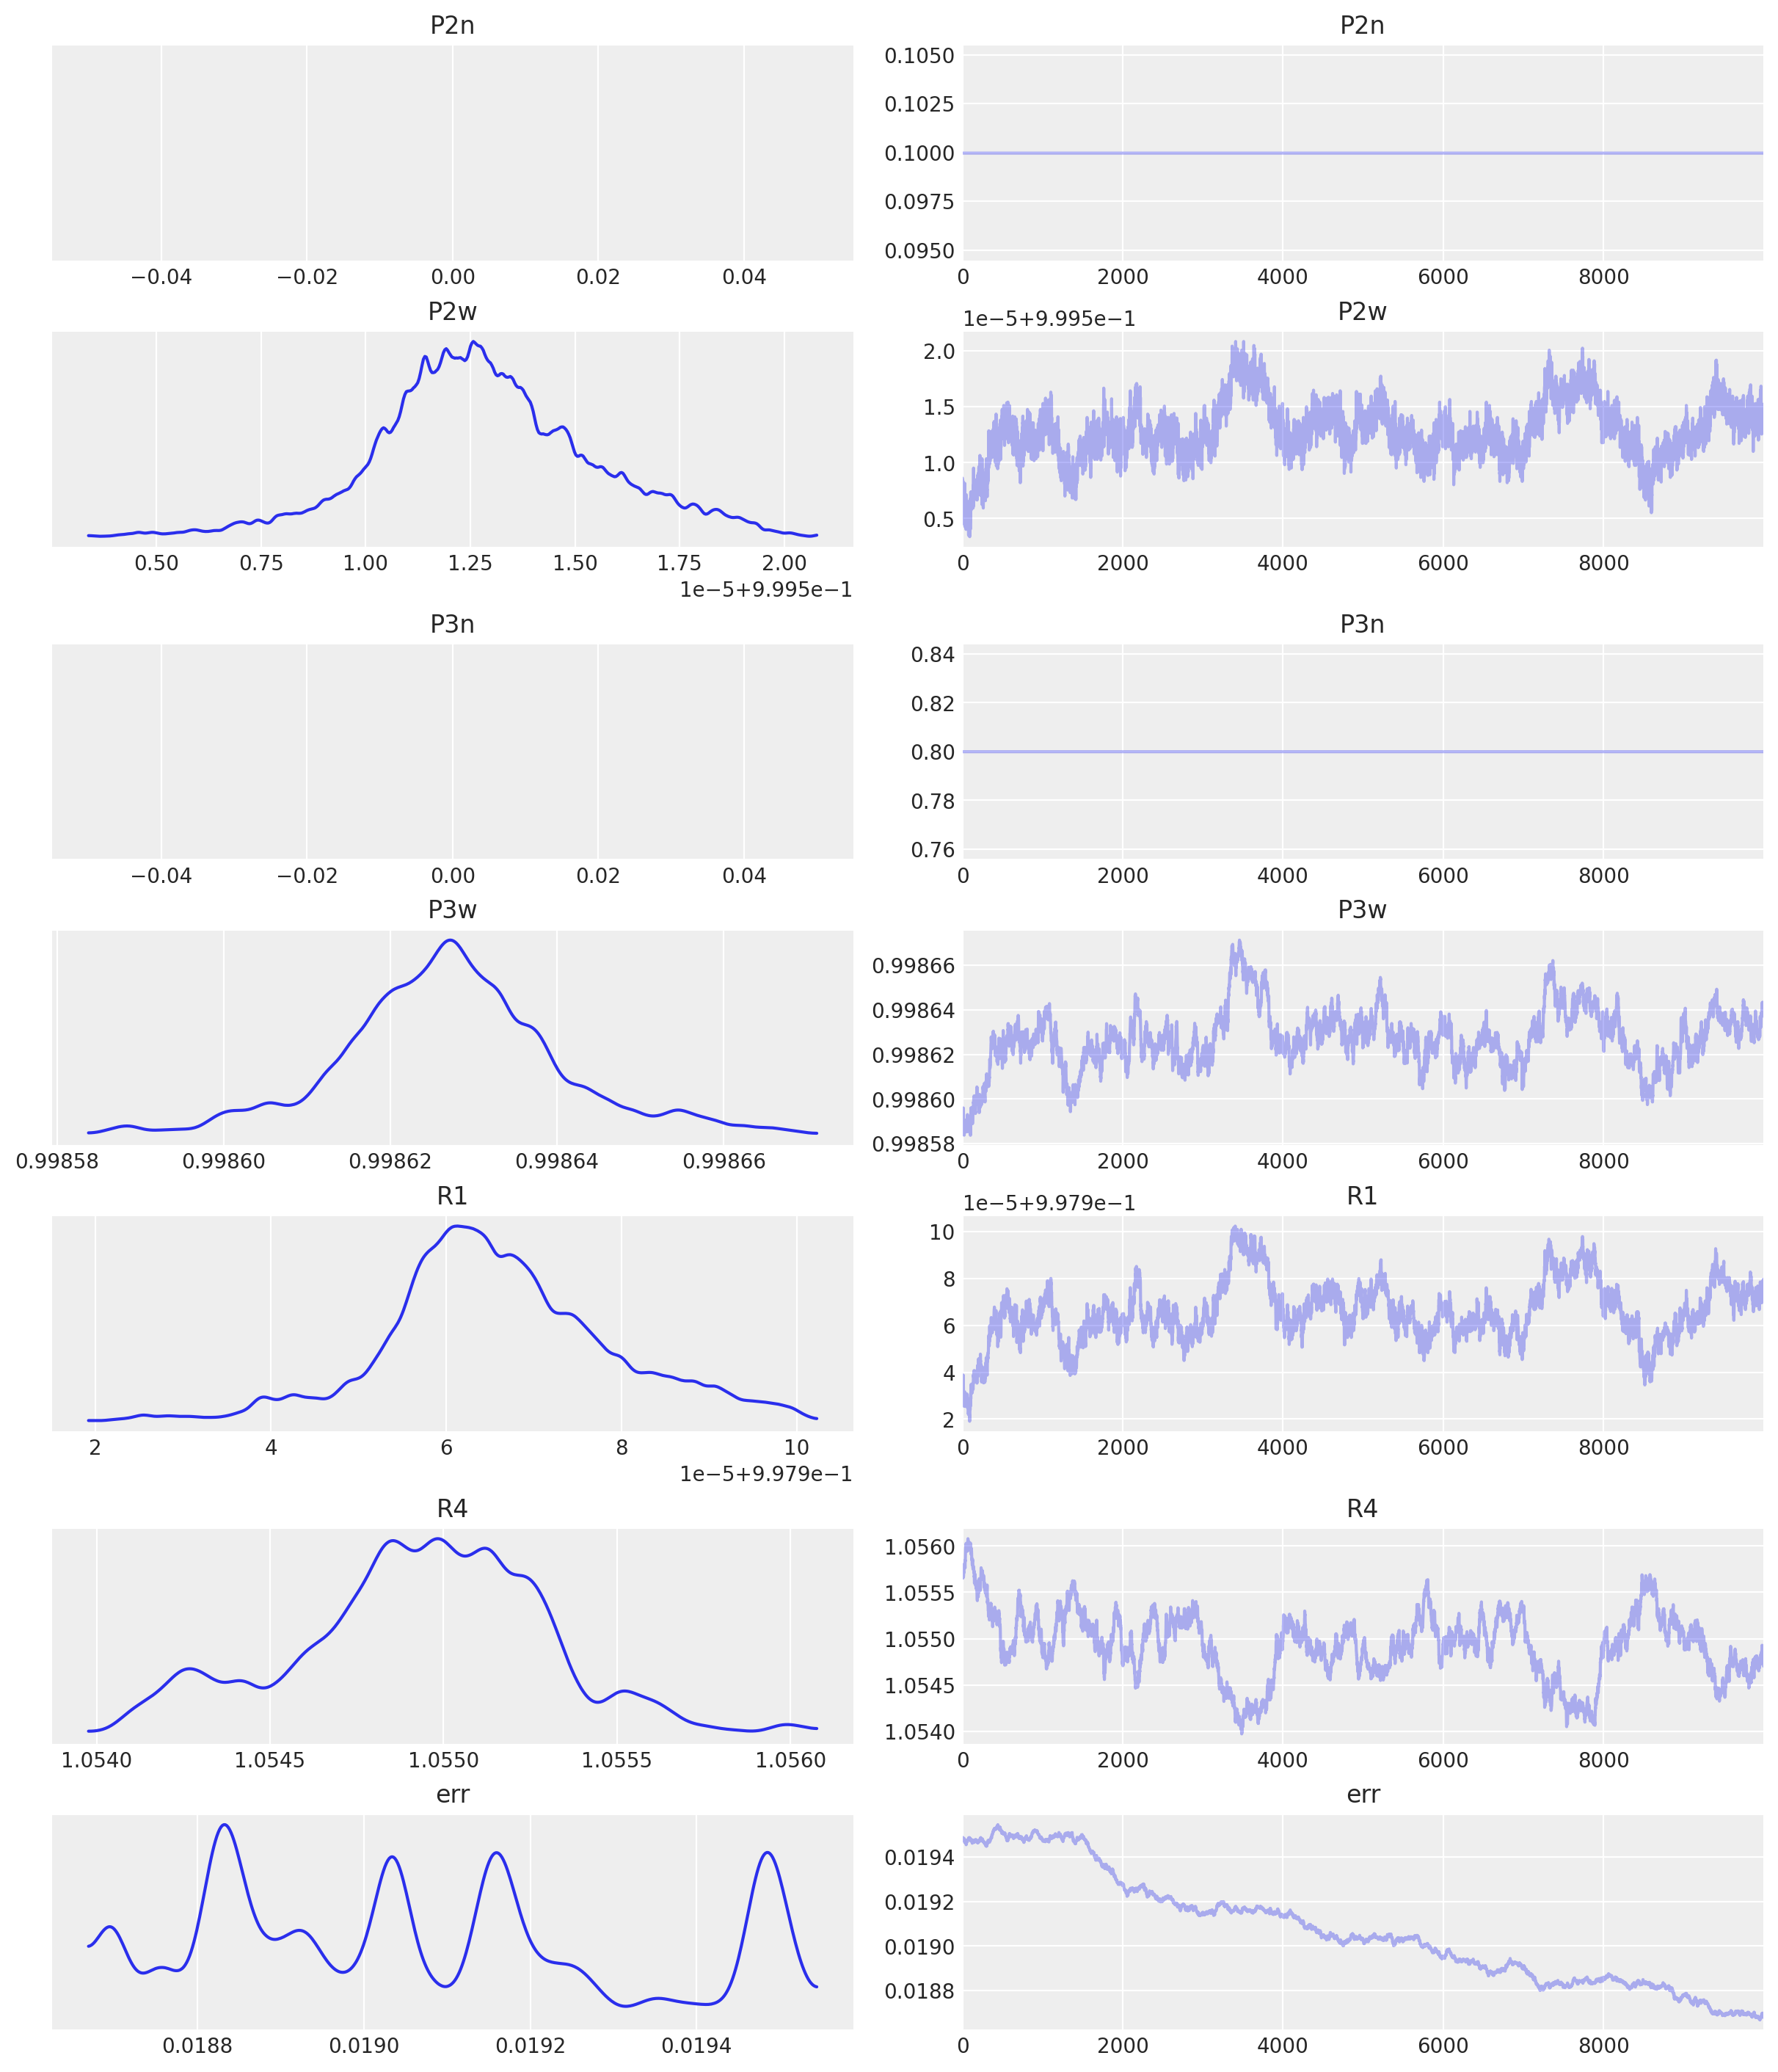

In [180]:
import arviz as az
az.plot_trace(out["Traces"][0])


sample: 100%|██████████| 11000/11000 [40:23<00:00,  4.54it/s, 1023 steps of size 7.93e-07. acc. prob=0.86]


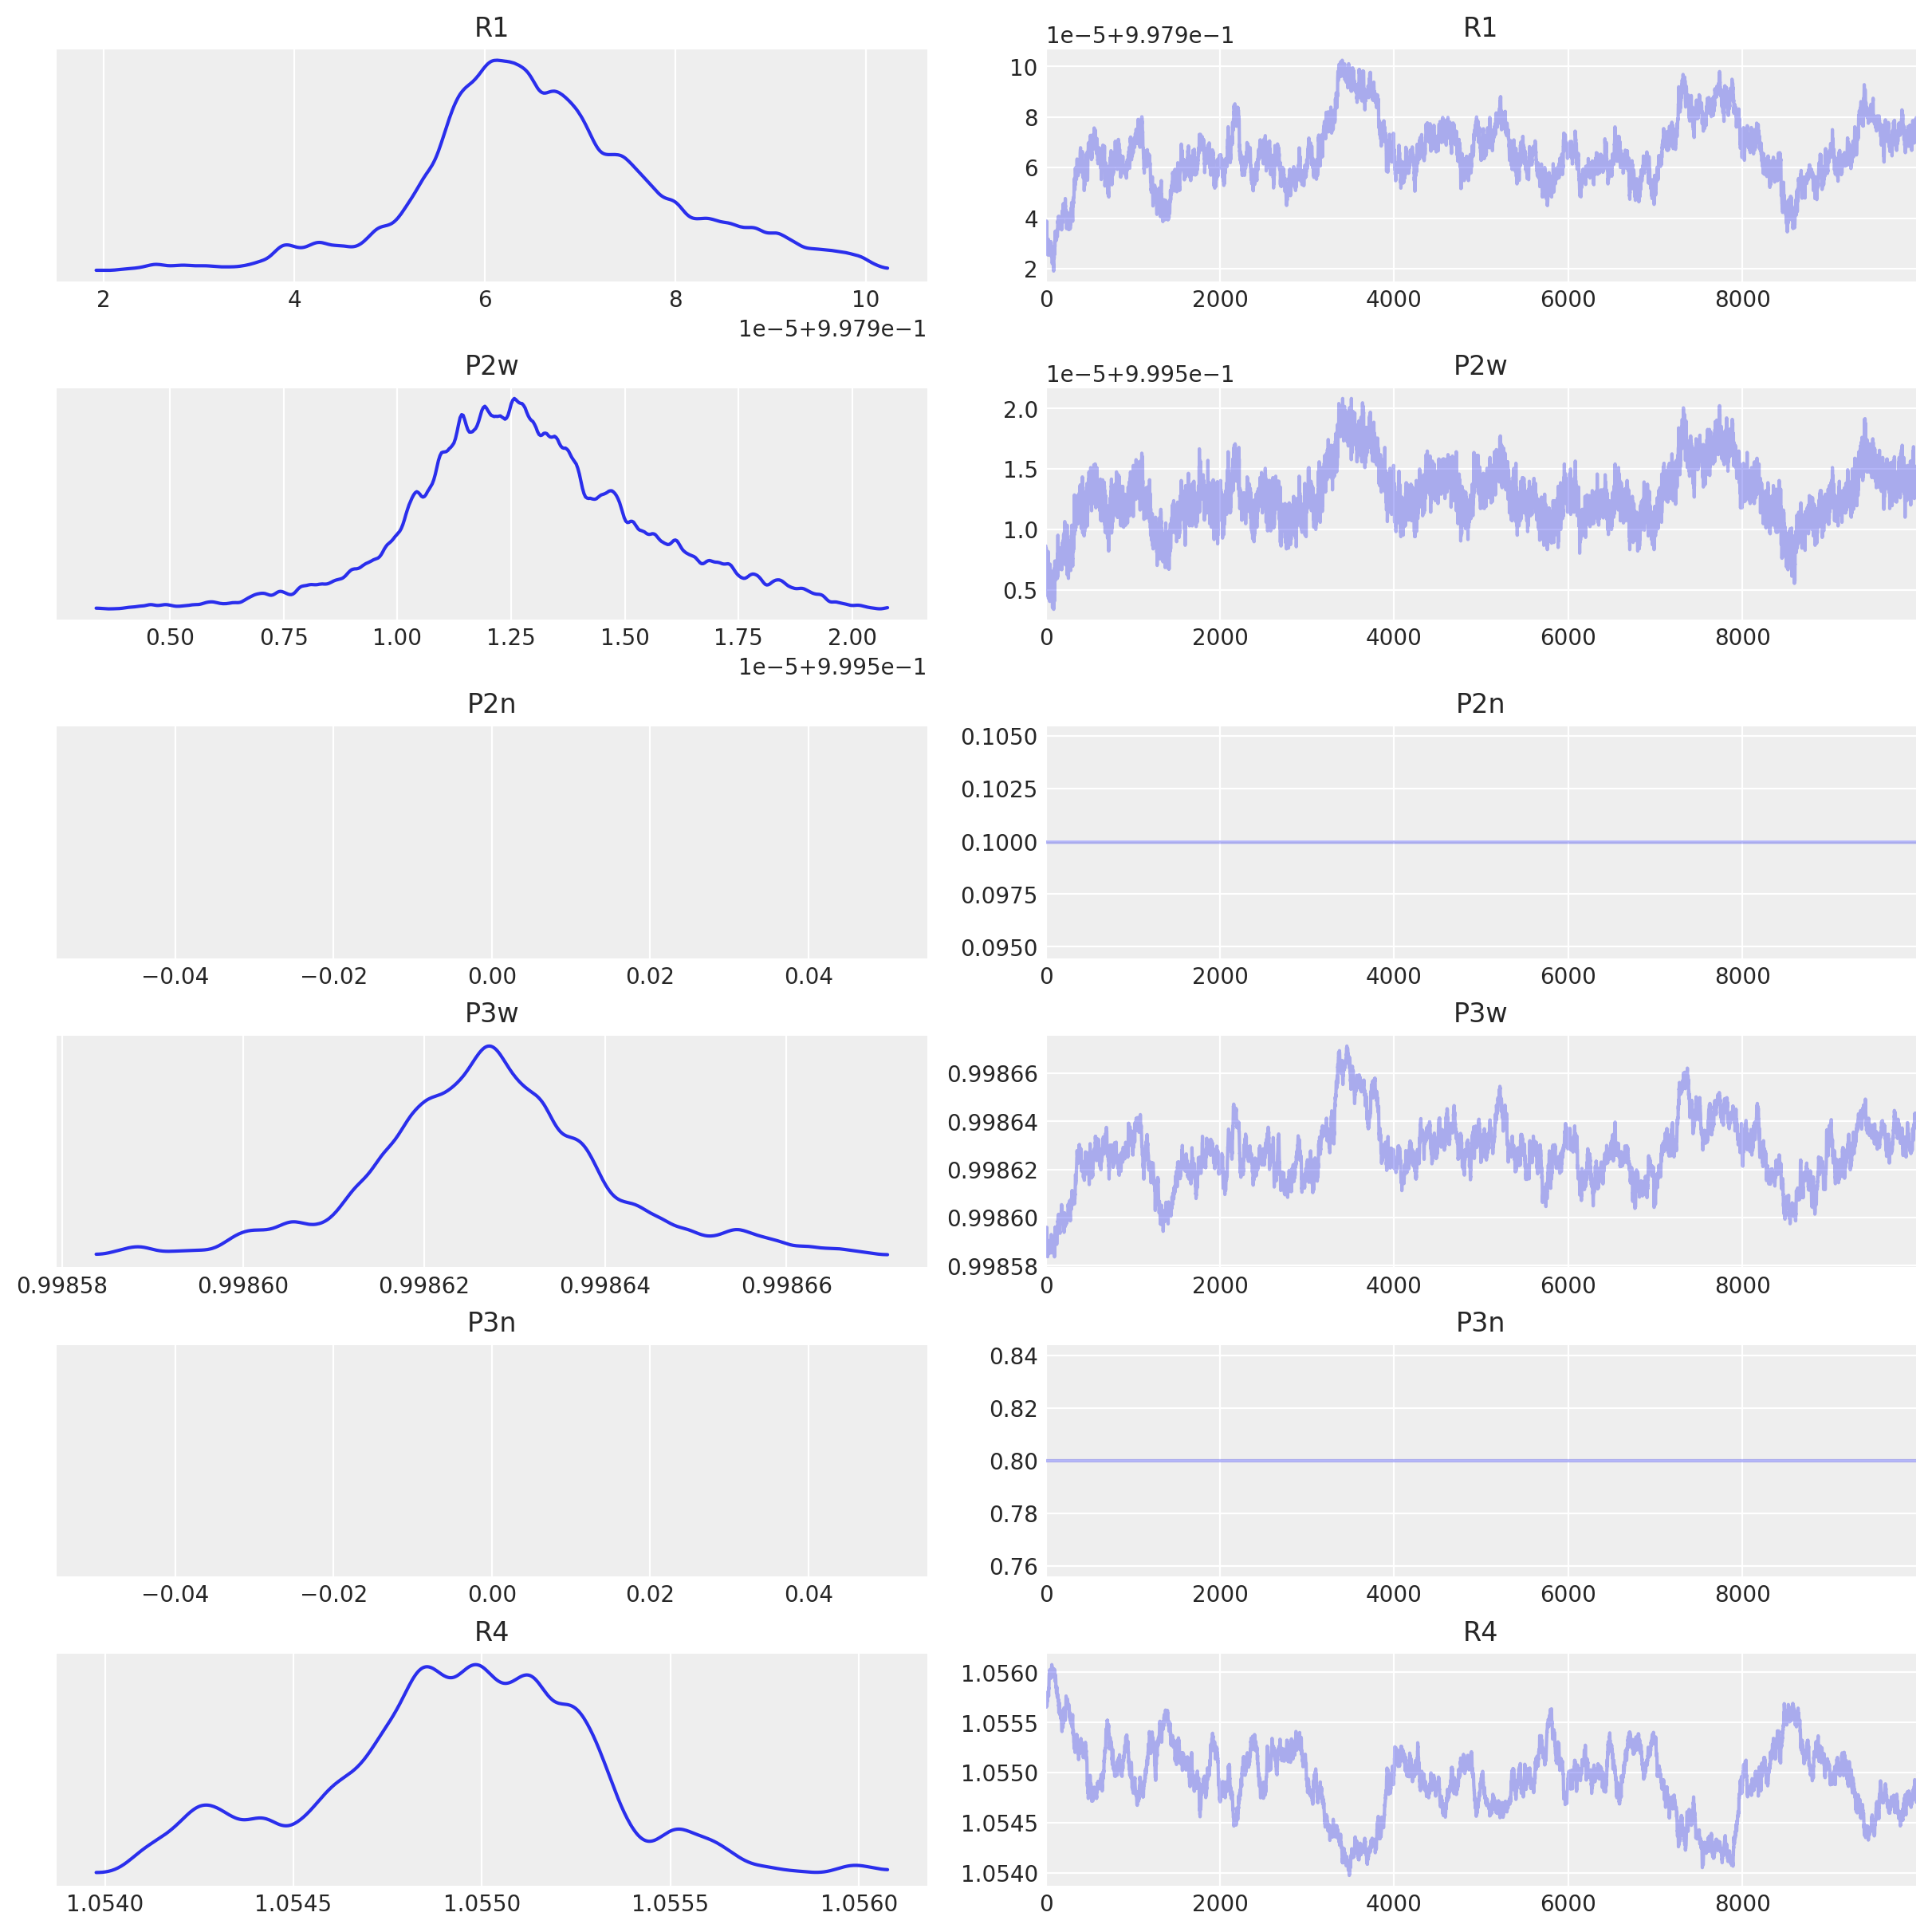

In [168]:
eis_data = pd.DataFrame({"freq": freq, "Zreal": Zreal, "Zimag": Zimag})
out = ae.perform_bayesian_inference(eis_data, ecms=circuits)


In [165]:
eis_data = pd.read_csv("assets/testdata_RZ.csv")
freq = eis_data["freq"]
Z = eis_data["Zreal"].to_numpy() + 1j * eis_data["Zimag"].to_numpy()
circuits = pd.read_csv("assets/circuits_RZ.csv")
R = ae.core.find_ohmic_resistance(Z, freq)
circuits = ae.core.apply_heuristic_rules(circuits, ohmic_resistance=R)
out = ae.perform_bayesian_inference(eis_data, ecms=circuits, plot=False)


X[0]+(1/(X[1]*(2*1j*jnp.pi*F)**(X[2])))+(((1/(X[3]*(2*1j*jnp.pi*F)**(X[4]))))**(-1)+(X[5])**(-1))**(-1)+(((1/(X[6]*(2*1j*jnp.pi*F)**(X[7]))))**(-1)+(X[8])**(-1))**(-1)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│   4 circuits = pd.read_csv("assets/circuits_RZ.csv")                                             │
│   5 R = ae.core.find_ohmic_resistance(Z, freq)                                                   │
│   6 circuits = ae.core.apply_heuristic_rules(circuits, ohmic_resistance=R)                       │
│ ❱ 7 out = ae.perform_bayesian_inference(eis_data, ecms=circuits, plot=False)                     │
│   8                                                                                              │
│                                                                                                  │
│ /home/amin/Code/AutoEIS/autoeis/core.py:1514 in perform_bayesian_inference                       │
│                                                                                                  │
│   1511 │   │   # function_i = eval(f"lambda X,F:{expression_str_i}")                             │
│   1512 │   │   function_i = lambda X, F: eval(expression_str_i)                                  │
│   1513 │   │   print(expression_str_i)                                                           │
│ ❱ 1514 │   │   qq                                                                                │
│   1515 │   │                                                                                     │
│   1516 │   │   log.info(f"Circuit {i}: {circuit_name_i}")                                        │
│   1517 │   │   log.info(f"Elements: ({name_i})\nValues: ({value_i})")                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'qq' is not defined

In [ ]:
eqn = circuits_test["Mathematical expressions"]

expr = eqn
for i in range(1000):
    expr = expr.replace(f"X[{i}]", f"x{i}")
    if expr.find(f"X[{i+1}]") == -1:
        break
expr = expr.replace("np.pi", "pi")

# x0, x1, x2, x3, x4, x5, x6, x7, F = symbols("x0 x1 x2 x3 x4 x5 x6 x7 F")
# expr = sympify(expr)
# f2 = lambdify((x0, x1, x2, x3, x4, x5, x6, x7, F), expr, "numpy")
# f(1, 2, 3, 4, 5, 6, 7, 8)
# ae.visualization.draw_circuit(circuits_test["Combined Circuits"][0])

# f = eval(f"lambda F, X: {eqn}")
# x = circuits_test["Variables_values"]


In [ ]:
results = []
maxiter = 1

circuits_test = circuits.iloc[0:10, :]
circuits_test.reset_index(drop=True, inplace=True)

failed_indices = []

# Iterate over all ECMs and find the best one
for index, row in circuits_test.iterrows():
    print(index)
    circuit = pd.DataFrame([row], index=[0])
    for i in range(maxiter):
        try:
            result = ae.perform_bayesian_inference(
                eis_data=eis_data, ecms=circuit, saveto=None, plot=False
            )
        except RuntimeError:
            result = None
            failed_indices.append(index)
        if result is not None:
            break
    print(f"Exited after {i+1} iterations")
    results.append(result)

# Save the results in a csv file
# results = pd.concat(results)
# results.to_csv("PJ122_Charged_ECM_output_016_07.csv", index=False)
